In [1]:
import os
import numpy as np
from PIL import Image
from scipy.io import loadmat
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dataset Paths
datasets_train = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth")
]

datasets_test = [
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_A/test_data/ground-truth"),
    ("/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/images",
     "/content/drive/MyDrive/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth")
]

In [4]:
# Parameters
IMAGE_SIZE = (300, 300)
NUM_CLASSES = 2  # Low, High crowd density classes

# Extract head count from ground truth
def get_head_count(gt_file_path):
    gt_data = loadmat(gt_file_path)
    head_count = len(gt_data["image_info"][0][0][0][0][0])
    return head_count

# Load ResNet34 as feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet34 = models.resnet34(pretrained=True)
resnet34 = nn.Sequential(*list(resnet34.children())[:-1])  # Remove final classification layer
resnet34.to(device)
resnet34.eval()

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess images and extract features
def load_features_and_labels(dataset_paths):
    features = []
    labels = []
    for dataset_path, ground_truth_path in dataset_paths:
        image_files = sorted(os.listdir(dataset_path), key=lambda x: int(x.split('_')[1].split('.')[0]))
        for img_file in image_files:
            img_path = os.path.join(dataset_path, img_file)
            gt_file = os.path.join(ground_truth_path, f"GT_{os.path.splitext(img_file)[0]}.mat")

            if os.path.exists(gt_file):
                head_count = get_head_count(gt_file)

                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img).unsqueeze(0).to(device)

                with torch.no_grad():
                    feature = resnet34(img_tensor).squeeze().cpu().numpy()

                features.append(feature)
                labels.append(0 if head_count <= 160 else 1)  # Low Density: 0, High Density: 1
    return np.array(features), np.array(labels)

# Load training and testing data
train_features, train_labels = load_features_and_labels(datasets_train)
test_features, test_labels = load_features_and_labels(datasets_test)

# Train Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_features, train_labels)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 59.3MB/s]


LogisticRegression(max_iter=1000)

Test Accuracy: 82.33%
Classification Report:
               precision    recall  f1-score   support

 Low Density       0.79      0.89      0.84       252
High Density       0.87      0.76      0.81       246

    accuracy                           0.82       498
   macro avg       0.83      0.82      0.82       498
weighted avg       0.83      0.82      0.82       498



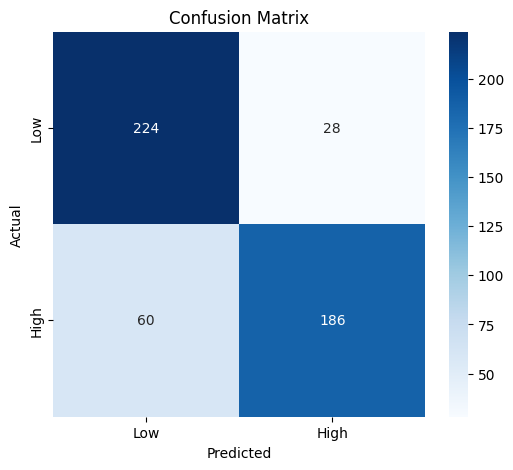

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the Logistic Regression model
accuracy = log_reg.score(test_features, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Make predictions
y_pred = log_reg.predict(test_features)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Compute classification report
report = classification_report(test_labels, y_pred, target_names=['Low Density', 'High Density'])

# Print metrics
print("Classification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
